# Planejamento ArtKakau

Nesse notebook Python eu vou implementar um programa que gera o planejamento, ao longo do tempo, das nosas finanças para alcançarmos os nosso objetivos.

Como por exemplo a compra da nossa casinha e da nossa moto elétrica para ser nosso meio de locomoção inicial.

O planejamento é um planejamento, ao longo do tempo podemos alterar ele caso surja oportunidades.

In [1]:
# Importações
import os
import math
import json
import requests
import pandas as pd
import numpy as np
from datetime import datetime, date, timedelta

import matplotlib.pyplot as plt

from reportlab.lib.pagesizes import A4
from reportlab.lib import colors
from reportlab.lib.units import cm
from reportlab.lib.styles import getSampleStyleSheet, ParagraphStyle
from reportlab.platypus import (
    SimpleDocTemplate, Paragraph, Spacer, Table, TableStyle,
    Image as RLImage, PageBreak
)

## CRIAÇÃO DO CSV DE APORTES (saldo tratado + Kakau)

### Carregar seu CSV e converter números “pt-BR”

In [2]:
INPUT_CSV  = "data/tabela_completa_final.csv"
OUTPUT_CSV = "data/aportes_casal_por_mes.csv"

KAKAU_APORTE_FIXO = 50.0

def to_float_mixed(x):
    """Converte strings numéricas com vírgula decimal (pt-BR) e casos mistos."""
    if pd.isna(x):
        return np.nan
    s = str(x).strip().replace(" ", "")
    if "," in s and "." in s:
        # se vier tipo "1.234,56" -> "1234.56"
        s = s.replace(".", "").replace(",", ".")
    elif "," in s:
        s = s.replace(",", ".")
    return float(s)

df = pd.read_csv(INPUT_CSV, sep=";")

# Converter colunas numéricas
for c in df.columns:
    if c != "mes":
        df[c] = df[c].apply(to_float_mixed)

df["mes"] = df["mes"].astype(str)

df.head()

,mes,cartao_total,desafio_52s_total,fixos_total,salario,extras_total,receita_total,despesas_total,saldo_mes
0,2026-02,1089.08,70.0,973.8,1400.0,326.40,1726.40,2132.88,-406.48
1,2026-03,654.49,200.0,1069.8,2000.0,256.40,2256.40,1924.29,332.11
2,2026-04,563.90,250.0,973.8,2000.0,280.12,2280.12,1787.70,492.42
3,2026-05,431.40,425.0,973.8,2000.0,210.12,2210.12,1830.20,379.92
4,2026-06,431.40,430.0,1013.8,2000.0,280.12,2280.12,1875.20,404.92


### Criar aporte do casal por mês (saldo negativo vira 0)

In [3]:
df_aporte = df[["mes", "saldo_mes"]].copy()

df_aporte["saldo_ajustado"] = df_aporte["saldo_mes"].clip(lower=0.0)
df_aporte["aporte_kakau"] = KAKAU_APORTE_FIXO
df_aporte["aporte_total_casal"] = df_aporte["saldo_ajustado"] + df_aporte["aporte_kakau"]

# Normalizar data do mês para facilitar simulação
df_aporte["mes_date"] = pd.to_datetime(df_aporte["mes"] + "-01")

df_aporte = df_aporte.sort_values("mes_date").reset_index(drop=True)

# Remover a primeira linha
df_aporte = df_aporte.iloc[1:].reset_index(drop=True)

df_aporte.to_csv(OUTPUT_CSV, index=False, encoding="utf-8")
OUTPUT_CSV, df_aporte.head(10)

('data/aportes_casal_por_mes.csv',
        mes  saldo_mes  saldo_ajustado  aporte_kakau  aporte_total_casal  \
 0  2026-03     332.11          332.11          50.0              382.11   
 1  2026-04     492.42          492.42          50.0              542.42   
 2  2026-05     379.92          379.92          50.0              429.92   
 3  2026-06     404.92          404.92          50.0              454.92   
 4  2026-07     254.92          254.92          50.0              304.92   
 5  2026-08      33.79           33.79          50.0               83.79   
 6  2026-09      99.86           99.86          50.0              149.86   
 7  2026-10      66.85           66.85          50.0              116.85   
 8  2026-11    -135.44            0.00          50.0               50.00   
 9  2026-12     -10.44            0.00          50.0               50.00   
 
     mes_date  
 0 2026-03-01  
 1 2026-04-01  
 2 2026-05-01  
 3 2026-06-01  
 4 2026-07-01  
 5 2026-08-01  
 6 2026-09-01  

## PLANEJAMENTO DINÂMICO (metas + Tesouro Selic + impostos + resgate mês a mês) + PDF

### Buscar SELIC online em tempo de execução (BCB / SGS)

Vou usar a API oficial do Banco Central (SGS) e pegar o valor mais recente da Meta Selic (% a.a.) pela série 432, via endpoint padrão do BCData/SGS.

In [4]:
def fetch_selic_meta_aa_percent():
    """
    Busca a Selic Meta (% a.a.) mais recente na API do BCB (SGS).
    Série 432 = "Taxa de juros - Meta Selic definida pelo Copom (% a.a.)"
    """
    # pega uma janela grande para garantir que vem o último valor
    today = date.today()
    start = today - timedelta(days=365*5)

    url = (
        "https://api.bcb.gov.br/dados/serie/bcdata.sgs.432/dados"
        f"?formato=json&dataInicial={start.strftime('%d/%m/%Y')}"
        f"&dataFinal={today.strftime('%d/%m/%Y')}"
    )

    r = requests.get(url, timeout=20)
    r.raise_for_status()
    data = r.json()

    if not data:
        raise RuntimeError("BCB retornou vazio para a série 432.")

    last = data[-1]  # último registro
    # last = {'data': 'dd/mm/aaaa', 'valor': 'xx.xx'}
    selic_aa = float(str(last["valor"]).replace(",", "."))
    selic_ref = last["data"]
    return selic_aa, selic_ref

selic_aa, selic_ref = fetch_selic_meta_aa_percent()
selic_aa, selic_ref

(15.0, '13/02/2026')

### JSON de metas (dinâmico, com prioridade

Você pediu: nome, valor, descrição, prioridade (numérica).

In [5]:
GOALS_JSON = {
    "owner_1": "Arthur Stiegler",
    "owner_2": "Kauany Ferreira",
    "goals": [
        {
            "name": "Meio de locomoção (Moto elétrica)",
            "target_value": 12000.0,
            "priority": 1,
            "description": "Meta para compra de moto elétrica (aprox. 12k)."
        },
        {
            "name": "Entrada da casa (Financiamento)",
            "target_value": 50000.00,
            "priority": 2,
            "description": "Acumular valor para entrada de financiamento imobiliário (estimado 300k)."
        }
    ]
}

# Ordenar por prioridade
goals = sorted(GOALS_JSON["goals"], key=lambda g: g["priority"])
goals

[{'name': 'Meio de locomoção (Moto elétrica)',
  'target_value': 12000.0,
  'priority': 1,
  'description': 'Meta para compra de moto elétrica (aprox. 12k).'},
 {'name': 'Entrada da casa (Financiamento)',
  'target_value': 50000.0,
  'priority': 2,
  'description': 'Acumular valor para entrada de financiamento imobiliário (estimado 300k).'}]

### Regras de IR/IOF (renda fixa)

* IR regressivo: 22,5% até 180 dias; 20% até 360; 17,5% até 720; 15% acima.
* IOF: só até 29 dias, regressivo e zera no 30º.

In [6]:
def ir_aliquota_por_dias(dias: int) -> float:
    if dias <= 180:
        return 0.225
    if dias <= 360:
        return 0.20
    if dias <= 720:
        return 0.175
    return 0.15

# IOF regressivo (percentual sobre o rendimento), dia 1..30
# tabela padrão: 96%, 93%, 90% ... 3%, 0%
IOF_TABLE = {
    1: 0.96,  2: 0.93,  3: 0.90,  4: 0.86,  5: 0.83,
    6: 0.80,  7: 0.76,  8: 0.73,  9: 0.70, 10: 0.66,
    11: 0.63, 12: 0.60, 13: 0.56, 14: 0.53, 15: 0.50,
    16: 0.46, 17: 0.43, 18: 0.40, 19: 0.36, 20: 0.33,
    21: 0.30, 22: 0.26, 23: 0.23, 24: 0.20, 25: 0.16,
    26: 0.13, 27: 0.10, 28: 0.06, 29: 0.03, 30: 0.00
}

def iof_aliquota_por_dias(dias: int) -> float:
    if dias >= 30:
        return 0.0
    if dias <= 0:
        return 0.96
    return IOF_TABLE.get(dias, 0.0)

### Simulação do Tesouro Selic (mensal, com “resgate em cada mês”)

Modelo (prático e transparente):
* Converte SELIC anual para taxa mensal efetiva: (1 + 𝑟 ) 1 / 12 − 1 (1+r) 1/12 −1
* Considera aporte no início do mês e rendimento até o final do mês
* Mantém “lotes” para calcular IR por prazo de cada aporte
* Para cada mês, calcula:
    * saldo bruto acumulado
    * rendimento acumulado
    * quanto sairia líquido se resgatar naquele mês (com IOF/IR)

In [7]:
def taxa_mensal_efetiva(a_a_percent: float) -> float:
    r = a_a_percent / 100.0
    return (1 + r) ** (1/12) - 1

def month_end(d: pd.Timestamp) -> pd.Timestamp:
    # último dia do mês
    return (d + pd.offsets.MonthEnd(0)).to_pydatetime().date()

def simulate_investment(df_aporte: pd.DataFrame, selic_aa_percent: float):
    """
    Simula um 'pool' de Tesouro Selic com aportes mensais.
    Retorna um dataframe com projeção e valores líquidos de resgate por mês.
    """
    m_rate = taxa_mensal_efetiva(selic_aa_percent)

    lots = []  # cada lote: {"principal": x, "value": y, "start_date": date}

    rows = []

    for _, row in df_aporte.iterrows():
        mes = row["mes"]
        mes_date = pd.to_datetime(row["mes_date"]).date()
        aporte = float(row["aporte_total_casal"])

        # Aporte no começo do mês
        if aporte > 0:
            lots.append({
                "principal": aporte,
                "value": aporte,
                "start_date": mes_date
            })

        # Render no mês: aplica crescimento mensal igual para todos os lotes (aprox.)
        for lot in lots:
            lot["value"] *= (1 + m_rate)

        # Saldo bruto do pool
        gross = sum(l["value"] for l in lots)
        principal_total = sum(l["principal"] for l in lots)
        gain_total = gross - principal_total

        # Se resgatar tudo no fim do mês: calcular IOF+IR lote a lote
        end_date = month_end(pd.to_datetime(mes + "-01"))
        net_total = 0.0
        iof_total = 0.0
        ir_total = 0.0

        for lot in lots:
            gain = max(0.0, lot["value"] - lot["principal"])
            dias = (end_date - lot["start_date"]).days

            iof_rate = iof_aliquota_por_dias(dias)
            iof = gain * iof_rate

            taxable_gain = max(0.0, gain - iof)
            ir_rate = ir_aliquota_por_dias(dias)
            ir = taxable_gain * ir_rate

            net = lot["principal"] + gain - iof - ir

            net_total += net
            iof_total += iof
            ir_total += ir

        rows.append({
            "mes": mes,
            "aporte_total_casal": aporte,
            "selic_aa_percent": selic_aa_percent,
            "taxa_mensal_efetiva": m_rate,
            "saldo_bruto": gross,
            "principal_acumulado": principal_total,
            "rendimento_bruto_acumulado": gain_total,
            "iof_estimado_no_resgate": iof_total,
            "ir_estimado_no_resgate": ir_total,
            "saldo_liquido_se_resgatar_no_mes": net_total,
        })

    return pd.DataFrame(rows)

df_proj = simulate_investment(df_aporte, selic_aa)
df_proj.head(8)

,mes,aporte_total_casal,selic_aa_percent,taxa_mensal_efetiva,saldo_bruto,principal_acumulado,rendimento_bruto_acumulado,iof_estimado_no_resgate,ir_estimado_no_resgate,saldo_liquido_se_resgatar_no_mes
0,2026-03,382.11,15.0,0.011715,386.586387,382.11,4.476387,0.000000,1.007187,385.579200
1,2026-04,542.42,15.0,0.011715,939.889620,924.53,15.359620,0.190632,3.413022,936.285965
2,2026-05,429.92,15.0,0.011715,1385.856825,1354.45,31.406825,0.000000,7.066536,1378.790290
3,2026-06,454.92,15.0,0.011715,1862.341373,1809.37,52.971373,0.159881,11.882586,1850.298907
4,2026-07,304.92,15.0,0.011715,2192.650660,2114.29,78.360660,0.000000,17.631148,2175.019511
5,2026-08,83.79,15.0,0.011715,2303.108973,2198.08,105.028973,0.000000,22.940086,2280.168887
6,2026-09,149.86,15.0,0.011715,2481.705301,2347.94,133.765301,0.052668,28.292383,2453.360250
7,2026-10,116.85,15.0,0.011715,2628.997160,2464.79,164.207160,0.000000,34.083932,2594.913228


In [8]:
# Salvando projeção
PROJ_CSV = "data/projecao_tesouro_selic_casal.csv"
df_proj.to_csv(PROJ_CSV, index=False, encoding="utf-8")
PROJ_CSV

'data/projecao_tesouro_selic_casal.csv'

### Planejamento por metas (prioridade) usando o saldo líquido do mês

Agora vamos calcular em que mês cada meta seria atingida, considerando o valor líquido se resgatar (mais conservador do que usar bruto).

In [9]:
def plan_goals_by_priority(df_proj: pd.DataFrame, goals: list):
    """
    Usa o saldo líquido (se resgatar no mês) como referência conservadora
    para dizer quando cada meta seria atingida.
    """
    results = []
    for g in goals:
        target = float(g["target_value"])
        hit_row = df_proj[df_proj["saldo_liquido_se_resgatar_no_mes"] >= target].head(1)
        if len(hit_row) == 0:
            results.append({
                "priority": g["priority"],
                "goal": g["name"],
                "target_value": target,
                "hit_month": None,
                "hit_net_value": None,
                "description": g.get("description","")
            })
        else:
            r = hit_row.iloc[0]
            results.append({
                "priority": g["priority"],
                "goal": g["name"],
                "target_value": target,
                "hit_month": r["mes"],
                "hit_net_value": float(r["saldo_liquido_se_resgatar_no_mes"]),
                "description": g.get("description","")
            })
    return pd.DataFrame(results).sort_values("priority")

df_goals_plan = plan_goals_by_priority(df_proj, goals)
df_goals_plan

,priority,goal,target_value,hit_month,hit_net_value,description
0,1,Meio de locomoção (Moto elétrica),12000.0,2027-10,12616.27146,Meta para compra de moto elétrica (aprox. 12k).
1,2,Entrada da casa (Financiamento),50000.0,None,NaN,Acumular valor para entrada de financiamento i...


In [10]:
## Salavando Plano das Metas
GOALS_PLAN_CSV = "data/planejamento_metas_prioridade.csv"
df_goals_plan.to_csv(GOALS_PLAN_CSV, index=False, encoding="utf-8")
GOALS_PLAN_CSV

'data/planejamento_metas_prioridade.csv'

## RELATÓRIO PDF (estilizado)

### Gerar gráficos (imagens) para embutir no PDF

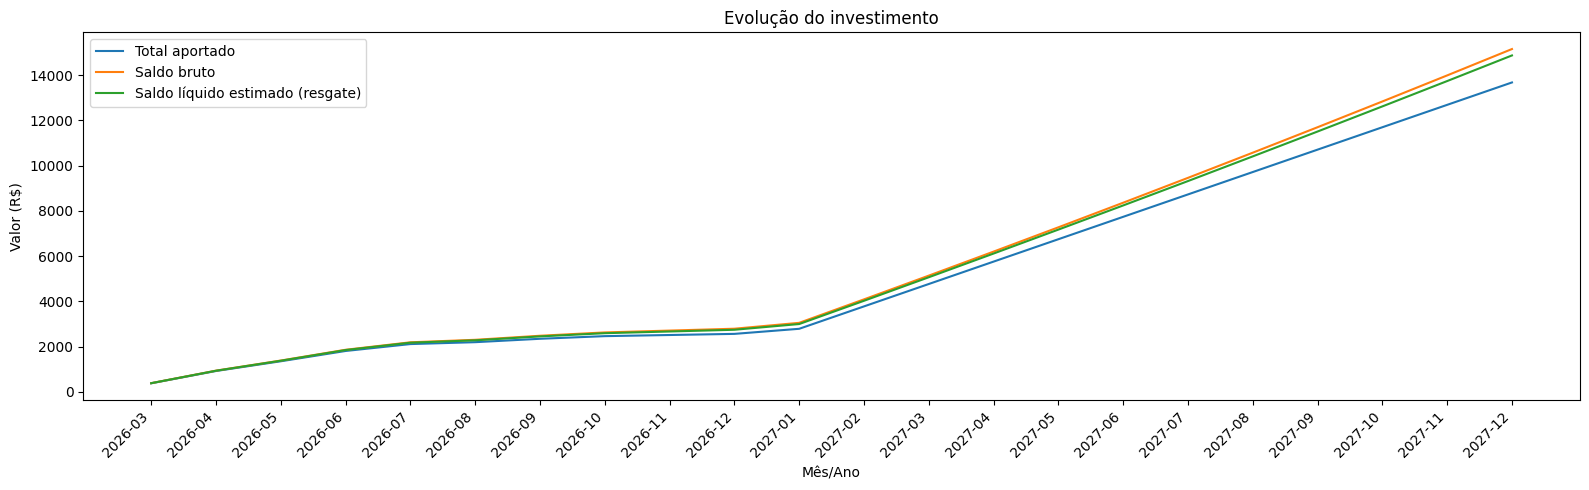

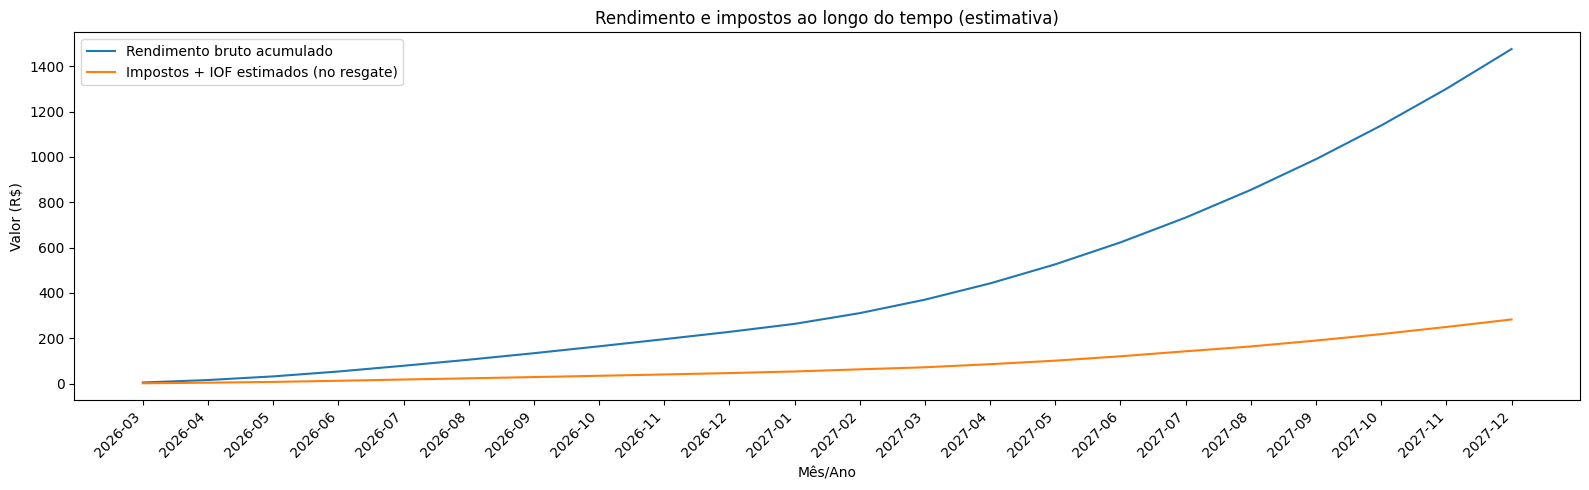

Gráficos atualizados com sucesso.


In [11]:
# ============================
# NOVA VERSÃO DOS GRÁFICOS
# ============================
OUT_DIR = "data/relatorio_assets"
os.makedirs(OUT_DIR, exist_ok=True)

df_plot = df_proj.copy()
df_plot["mes_str"] = df_plot["mes"].astype(str)

# ----------------------------
# Cálculos auxiliares
# ----------------------------

df_plot["total_aportado_acumulado"] = df_plot["aporte_total_casal"].cumsum()

df_plot["rendimento_bruto_acumulado_calc"] = (
    df_plot["saldo_bruto"] - df_plot["total_aportado_acumulado"]
)

df_plot["impostos_iof_estimado_acumulado"] = (
    df_plot["saldo_bruto"] - df_plot["saldo_liquido_se_resgatar_no_mes"]
)

# ============================
# GRÁFICO 1 — EVOLUÇÃO TOTAL
# ============================

graf_evolucao = os.path.join(OUT_DIR, "evolucao_investimento.png")

plt.figure(figsize=(16,5))

plt.plot(df_plot["mes_str"], df_plot["total_aportado_acumulado"], label="Total aportado")
plt.plot(df_plot["mes_str"], df_plot["saldo_bruto"], label="Saldo bruto")
plt.plot(df_plot["mes_str"], df_plot["saldo_liquido_se_resgatar_no_mes"], label="Saldo líquido estimado (resgate)")

plt.title("Evolução do investimento")
plt.xlabel("Mês/Ano")
plt.ylabel("Valor (R$)")

step = max(1, len(df_plot)//20)
plt.xticks(df_plot.index[::step],
           df_plot["mes_str"].iloc[::step],
           rotation=45,
           ha="right")

plt.legend()
plt.tight_layout()
plt.savefig(graf_evolucao, dpi=200)
plt.show()

# ============================
# GRÁFICO 2 — RENDIMENTO x IMPOSTOS
# ============================

graf_rendimento_impostos = os.path.join(OUT_DIR, "rendimento_vs_impostos.png")

plt.figure(figsize=(16,5))

plt.plot(df_plot["mes_str"], df_plot["rendimento_bruto_acumulado_calc"], label="Rendimento bruto acumulado")
plt.plot(df_plot["mes_str"], df_plot["impostos_iof_estimado_acumulado"], label="Impostos + IOF estimados (no resgate)")

plt.title("Rendimento e impostos ao longo do tempo (estimativa)")
plt.xlabel("Mês/Ano")
plt.ylabel("Valor (R$)")

plt.xticks(df_plot.index[::step],
           df_plot["mes_str"].iloc[::step],
           rotation=45,
           ha="right")

plt.legend()
plt.tight_layout()
plt.savefig(graf_rendimento_impostos, dpi=200)
plt.show()

print("Gráficos atualizados com sucesso.")

### Montar o PDF (ReportLab)

In [12]:
import math
import numpy as np
import pandas as pd
from datetime import datetime

from reportlab.lib.pagesizes import A4
from reportlab.lib import colors
from reportlab.lib.units import cm
from reportlab.lib.styles import getSampleStyleSheet, ParagraphStyle
from reportlab.platypus import (
    SimpleDocTemplate, Paragraph, Spacer, Table, TableStyle,
    Image as RLImage, PageBreak, HRFlowable
)

PDF_PATH = "Relatorio_Planejamento_Tesouro_Selic_Arthur_Stiegler_Kauany_Ferreira.pdf"

def money(x):
    if x is None or (isinstance(x, float) and np.isnan(x)):
        return "-"
    return f"R$ {x:,.2f}".replace(",", "X").replace(".", ",").replace("X", ".")

def percent(x):
    return f"{x:.2f}%".replace(".", ",")

def months_to_years_months(months: int):
    years = months // 12
    rem = months % 12
    return years, rem

def ym_months_between(start_ym: str, end_ym: str) -> int:
    dt0 = pd.to_datetime(start_ym + "-01")
    dt1 = pd.to_datetime(end_ym + "-01")
    return int((dt1.year - dt0.year) * 12 + (dt1.month - dt0.month))

def build_pdf_report(pdf_path: str, df_aporte, df_proj, df_goals_plan, selic_aa, selic_ref, assets_paths):
    doc = SimpleDocTemplate(
        pdf_path,
        pagesize=A4,
        leftMargin=2*cm,
        rightMargin=2*cm,
        topMargin=1.8*cm,
        bottomMargin=1.8*cm
    )

    styles = getSampleStyleSheet()

    # -------------------------
    # Estilos (premium) — TUNADOS p/ não ficar "grudado" nem "espaçado demais"
    # -------------------------
    styles.add(ParagraphStyle(
        name="TitleH1",
        parent=styles["Title"],
        fontSize=19,
        leading=24,
        spaceAfter=8,
        textColor=colors.HexColor("#111827")
    ))
    styles.add(ParagraphStyle(
        name="H2B",
        parent=styles["Heading2"],
        fontSize=13,
        leading=16,
        spaceBefore=10,
        spaceAfter=6,
        textColor=colors.HexColor("#111827")
    ))
    styles.add(ParagraphStyle(
        name="Body",
        parent=styles["BodyText"],
        fontSize=10.6,
        leading=14.2,
        textColor=colors.HexColor("#111827"),
        spaceAfter=2
    ))
    styles.add(ParagraphStyle(
        name="Small",
        parent=styles["BodyText"],
        fontSize=9.4,
        leading=12.4,
        textColor=colors.HexColor("#374151"),
        spaceAfter=2
    ))

    # Cards (reduzindo espaços)
    styles.add(ParagraphStyle(
        name="GoalCardTitle",
        parent=styles["BodyText"],
        fontSize=11.0,
        leading=13.2,
        textColor=colors.HexColor("#111827"),
        spaceAfter=4
    ))
    styles.add(ParagraphStyle(
        name="GoalCardLine",
        parent=styles["BodyText"],
        fontSize=9.7,
        leading=12.6,
        textColor=colors.HexColor("#111827"),
        spaceAfter=1
    ))
    styles.add(ParagraphStyle(
        name="GoalCardMuted",
        parent=styles["BodyText"],
        fontSize=9.2,
        leading=12.2,
        textColor=colors.HexColor("#374151"),
        spaceAfter=0
    ))

    # Callout separado + com respiro
    styles.add(ParagraphStyle(
        name="Callout",
        parent=styles["BodyText"],
        fontSize=9.5,
        leading=12.6,
        textColor=colors.HexColor("#111827"),
        backColor=colors.HexColor("#F9FAFB"),
        borderColor=colors.HexColor("#E5E7EB"),
        borderWidth=0.8,
        borderPadding=7,
        spaceBefore=0,
        spaceAfter=0
    ))

    story = []

    # =========================
    # Preparos / garantias
    # =========================
    df_proj = df_proj.copy()
    if "principal_acumulado" not in df_proj.columns:
        df_proj["principal_acumulado"] = df_proj["aporte_total_casal"].cumsum()

    goals_sorted = df_goals_plan.sort_values("priority").copy()

    # =========================
    # CAPA
    # =========================
    now_str = datetime.now().strftime("%d/%m/%Y %H:%M")

    story.append(Paragraph("<b>Relatório de Planejamento Financeiro — Metas do Casal</b>", styles["TitleH1"]))
    story.append(Paragraph("<b>Arthur Stiegler</b> &nbsp;&nbsp;|&nbsp;&nbsp; <b>Kauany Ferreira</b>", styles["Body"]))
    story.append(Spacer(1, 6))

    story.append(Paragraph(
        f"<b>Investimento simulado:</b> Tesouro Selic <i>(aproximação mensal)</i><br/>"
        f"<b>Selic Meta usada:</b> {percent(selic_aa)} a.a. <i>(referência BCB: {selic_ref})</i><br/>"
        f"<b>Regra de aporte:</b> saldo mensal <i>(negativo vira {money(0)})</i> + <b>{money(50)}</b> <i>(Kauany)</i><br/>"
        f"<b>Relatório gerado em:</b> {now_str}",
        styles["Small"]
    ))
    story.append(Spacer(1, 12))

    # =========================
    # RESUMO EXECUTIVO
    # =========================
    story.append(Paragraph("<b>Resumo executivo</b>", styles["H2B"]))

    total_aportes = float(df_proj["aporte_total_casal"].sum())
    saldo_final_bruto = float(df_proj["saldo_bruto"].iloc[-1])
    saldo_final_liquido = float(df_proj["saldo_liquido_se_resgatar_no_mes"].iloc[-1])
    principal_final = float(df_proj["principal_acumulado"].iloc[-1])
    rendimento_final = float(df_proj["rendimento_bruto_acumulado"].iloc[-1])

    resumo = (
        f"• <b>Total aportado</b>: <b>{money(total_aportes)}</b><br/>"
        f"• <b>Investido (principal)</b>: <b>{money(principal_final)}</b><br/>"
        f"• <b>Rendimento bruto acumulado</b>: <b>{money(rendimento_final)}</b><br/>"
        f"• <b>Saldo bruto final</b>: <b>{money(saldo_final_bruto)}</b><br/>"
        f"• <b>Saldo líquido final</b> <i>(resgate)</i>: <b>{money(saldo_final_liquido)}</b><br/>"
        f"• <i>Impostos</i> variam por prazo (IR regressivo) e IOF até 29 dias."
    )
    story.append(Paragraph(resumo, styles["Body"]))
    story.append(Spacer(1, 8))

    # =========================
    # METAS (TABELA)
    # =========================
    story.append(Paragraph("<b>Metas (ordem de prioridade)</b>", styles["H2B"]))

    th = ParagraphStyle(
        name="TableHeaderGoals",
        parent=styles["BodyText"],
        fontName="Helvetica-Bold",
        fontSize=9.0,
        leading=10.2,
        textColor=colors.white,
        alignment=1
    )
    tc = ParagraphStyle(
        name="TableCellGoals",
        parent=styles["BodyText"],
        fontSize=9.0,
        leading=10.6,
        textColor=colors.HexColor("#111827"),
    )

    goals_table_data = [[
        Paragraph("Prior.", th),
        Paragraph("Meta", th),
        Paragraph("Valor-alvo", th),
        Paragraph("Atinge em<br/>(disp.)", th),
        Paragraph("Disponível<br/>(líquido)", th),
    ]]

    start_month = str(df_proj["mes"].iloc[0])
    end_month   = str(df_proj["mes"].iloc[-1])
    net_series_total = df_proj["saldo_liquido_se_resgatar_no_mes"]

    reserved_prev = 0.0
    goals_hits = []

    for _, g in goals_sorted.iterrows():
        pr = int(g["priority"])
        goal_name = str(g["goal"])
        target = float(g["target_value"])

        available_series = (net_series_total - reserved_prev).clip(lower=0.0)

        hit_idx = available_series[available_series >= target].index
        if len(hit_idx) > 0:
            i0 = int(hit_idx[0])
            hit_month = str(df_proj.loc[i0, "mes"])
            hit_available = float(available_series.loc[i0])
        else:
            hit_month = None
            hit_available = None

        goals_hits.append({
            "priority": pr,
            "goal": goal_name,
            "target": target,
            "reserved_prev": reserved_prev,
            "hit_month": hit_month,
            "hit_available": hit_available,
            "available_series": available_series,
        })

        goals_table_data.append([
            Paragraph(str(pr), tc),
            Paragraph(goal_name, tc),
            Paragraph(money(target), tc),
            Paragraph(hit_month if hit_month else "Não atinge<br/>no período", tc),
            Paragraph(money(hit_available) if hit_available is not None else "-", tc),
        ])

        reserved_prev += target

    table_width = doc.width
    col_fracs = [0.10, 0.42, 0.16, 0.18, 0.14]
    col_widths = [table_width * f for f in col_fracs]

    goals_table = Table(goals_table_data, colWidths=col_widths, hAlign="LEFT")
    goals_table.setStyle(TableStyle([
        ("BACKGROUND", (0,0), (-1,0), colors.HexColor("#111827")),
        ("GRID", (0,0), (-1,-1), 0.25, colors.HexColor("#D1D5DB")),
        ("VALIGN", (0,0), (-1,-1), "MIDDLE"),
        ("ALIGN", (0,0), (-1,0), "CENTER"),
        ("ALIGN", (0,1), (0,-1), "CENTER"),
        ("ALIGN", (2,1), (2,-1), "RIGHT"),
        ("ALIGN", (3,1), (4,-1), "CENTER"),
        ("ROWBACKGROUNDS", (0,1), (-1,-1), [colors.white, colors.HexColor("#F9FAFB")]),
        ("TOPPADDING", (0,0), (-1,0), 5),
        ("BOTTOMPADDING", (0,0), (-1,0), 5),
        ("TOPPADDING", (0,1), (-1,-1), 3),
        ("BOTTOMPADDING", (0,1), (-1,-1), 3),
    ]))
    story.append(goals_table)
    story.append(Spacer(1, 10))

    # =========================
    # METAS (CARDS) — callout separado e com respiro (resolve "grudado")
    # =========================
    story.append(Paragraph("<b>Leitura das metas</b> <i>(explicação e prazo)</i>", styles["H2B"]))
    story.append(Spacer(1, 6))

    # Callout em bloco próprio (não grudado)
    story.append(Paragraph(
        "<b>Como interpretar:</b> para cada meta, usamos o <b>valor disponível</b> como "
        "<i>max(0, resgate líquido total − reservado para metas anteriores)</i>. "
        "Assim, o que já foi reservado (ex.: Meta 1) não conta duas vezes na Meta 2.",
        styles["Callout"]
    ))
    story.append(Spacer(1, 10))  # respiro depois do callout

    avg_monthly_aporte = float(df_proj["aporte_total_casal"].mean())
    saldo_final_net    = float(net_series_total.iloc[-1])

    def add_goal_card(title_html: str, lines_html: list, footer_html: str = None):
        card_rows = []
        card_rows.append([Paragraph(title_html, styles["GoalCardTitle"])])
        card_rows.append([HRFlowable(width="100%", thickness=0.6, color=colors.HexColor("#E5E7EB"),
                                     spaceBefore=2, spaceAfter=5)])
        for ln in lines_html:
            card_rows.append([Paragraph(ln, styles["GoalCardLine"])])
        if footer_html:
            card_rows.append([Spacer(1, 2)])
            card_rows.append([Paragraph(footer_html, styles["GoalCardMuted"])])

        card = Table(card_rows, colWidths=[doc.width])
        card.setStyle(TableStyle([
            ("BACKGROUND", (0,0), (-1,-1), colors.HexColor("#F9FAFB")),
            ("BOX", (0,0), (-1,-1), 0.8, colors.HexColor("#E5E7EB")),

            # paddings menores (remove espaços exagerados)
            ("LEFTPADDING", (0,0), (-1,-1), 9),
            ("RIGHTPADDING", (0,0), (-1,-1), 9),
            ("TOPPADDING", (0,0), (-1,-1), 6),
            ("BOTTOMPADDING", (0,0), (-1,-1), 6),
        ]))
        story.append(card)
        story.append(Spacer(1, 8))  # menos espaço entre cards

    for gh in goals_hits:
        pr = gh["priority"]
        goal_name = gh["goal"]
        target = gh["target"]
        reserved_prev = gh["reserved_prev"]
        hit_month = gh["hit_month"]
        hit_available = gh["hit_available"]

        title = f"<b>Meta {pr} — {goal_name}</b>"

        available_final = float(max(0.0, saldo_final_net - reserved_prev))
        lines = []
        lines.append(f"<b>Valor-alvo:</b> {money(target)}")
        if reserved_prev > 0:
            lines.append(f"<b>Já reservado antes:</b> {money(reserved_prev)}")
        lines.append(f"<b>Disponível ao final do período:</b> <b>{money(available_final)}</b>")

        if hit_month:
            months_needed = ym_months_between(start_month, hit_month)
            years, rem = months_to_years_months(months_needed)

            total_net_at_hit = float(df_proj.loc[df_proj["mes"] == hit_month, "saldo_liquido_se_resgatar_no_mes"].iloc[0])
            surplus = max(0.0, hit_available - target)

            lines.append(f"<b>Status:</b> ✅ <b>Atinge</b> em <b>{hit_month}</b>")
            lines.append(f"<b>Disponível no mês:</b> {money(hit_available)}")
            lines.append(f"<b>Sobra após cumprir:</b> {money(surplus)}")
            lines.append(f"<b>Tempo estimado:</b> <b>{months_needed}</b> meses (<b>{years}</b> ano(s) e <b>{rem}</b> mês(es))")

            footer = f"<i>Contexto:</i> no mês de atingimento, o resgate líquido total era {money(total_net_at_hit)}."
            add_goal_card(title, lines, footer_html=footer)
        else:
            falta = max(0.0, target - available_final)

            lines.append(f"<b>Status:</b> ⚠️ <b>Não atinge</b> no período ({start_month} → {end_month})")
            lines.append(f"<b>Falta estimada:</b> <b>{money(falta)}</b>")

            if avg_monthly_aporte > 0:
                months_extra = int(math.ceil(falta / avg_monthly_aporte))
                y2, r2 = months_to_years_months(months_extra)
                lines.append(f"<b>Estimativa (aporte médio):</b> +<b>{months_extra}</b> meses (~ <b>{y2}</b> ano(s) e <b>{r2}</b> mês(es))")
                footer = "<i>Nota:</i> estimativa simples (falta ÷ aporte médio). Mudanças de aporte e juros futuros alteram o prazo."
            else:
                footer = "<i>Nota:</i> não foi possível estimar prazo adicional (aporte médio ≈ 0)."

            add_goal_card(title, lines, footer_html=footer)

    # =========================
    # GRÁFICOS
    # =========================
    story.append(Paragraph("<b>Gráficos do planejamento</b>", styles["H2B"]))
    for img in assets_paths:
        story.append(RLImage(img, width=17.0*cm, height=6.6*cm))
        story.append(Spacer(1, 10))

    story.append(PageBreak())

    # =========================
    # PROJEÇÃO MÊS A MÊS (TABELA)
    # =========================
    story.append(Paragraph("<b>Projeção mês a mês (Tesouro Selic)</b>", styles["H2B"]))
    story.append(Paragraph(
        "‘Investido’ é a soma dos aportes (principal). ‘Saldo bruto’ = investido + rendimento. "
        "‘Resgate líquido’ desconta IOF/IR estimados no resgate total naquele mês.",
        styles["Small"]
    ))
    story.append(Spacer(1, 8))

    detail_cols = [
        "mes",
        "aporte_total_casal",
        "principal_acumulado",
        "saldo_bruto",
        "rendimento_bruto_acumulado",
        "iof_estimado_no_resgate",
        "ir_estimado_no_resgate",
        "saldo_liquido_se_resgatar_no_mes"
    ]

    th2 = ParagraphStyle(
        name="TableHeaderMonthly",
        parent=styles["BodyText"],
        fontName="Helvetica-Bold",
        fontSize=8.2,
        leading=9.4,
        textColor=colors.white,
        alignment=1
    )
    tc2 = ParagraphStyle(
        name="TableCellMonthly",
        parent=styles["BodyText"],
        fontSize=8.0,
        leading=10,
        textColor=colors.HexColor("#111827"),
    )

    detail_data = [[
        Paragraph("Mês", th2),
        Paragraph("Aporte", th2),
        Paragraph("Investido<br/>(principal)", th2),
        Paragraph("Saldo<br/>bruto", th2),
        Paragraph("Rendimento<br/>acumulado", th2),
        Paragraph("IOF<br/>(est.)", th2),
        Paragraph("IR<br/>(est.)", th2),
        Paragraph("Resgate<br/>líquido", th2),
    ]]

    for _, r in df_proj[detail_cols].iterrows():
        detail_data.append([
            Paragraph(str(r["mes"]), tc2),
            Paragraph(money(float(r["aporte_total_casal"])), tc2),
            Paragraph(money(float(r["principal_acumulado"])), tc2),
            Paragraph(money(float(r["saldo_bruto"])), tc2),
            Paragraph(money(float(r["rendimento_bruto_acumulado"])), tc2),
            Paragraph(money(float(r["iof_estimado_no_resgate"])), tc2),
            Paragraph(money(float(r["ir_estimado_no_resgate"])), tc2),
            Paragraph(money(float(r["saldo_liquido_se_resgatar_no_mes"])), tc2),
        ])

    table_width = doc.width
    col_fracs = [0.10, 0.11, 0.15, 0.12, 0.16, 0.10, 0.10, 0.16]
    col_widths = [table_width * f for f in col_fracs]

    t = Table(detail_data, colWidths=col_widths, hAlign="LEFT", repeatRows=1)
    t.setStyle(TableStyle([
        ("BACKGROUND", (0,0), (-1,0), colors.HexColor("#111827")),
        ("TEXTCOLOR", (0,0), (-1,0), colors.white),
        ("ALIGN", (0,0), (-1,0), "CENTER"),
        ("VALIGN", (0,0), (-1,0), "MIDDLE"),
        ("TOPPADDING", (0,0), (-1,0), 6),
        ("BOTTOMPADDING", (0,0), (-1,0), 6),

        ("GRID", (0,0), (-1,-1), 0.25, colors.HexColor("#D1D5DB")),
        ("ROWBACKGROUNDS", (0,1), (-1,-1), [colors.white, colors.HexColor("#F9FAFB")]),

        ("VALIGN", (0,1), (-1,-1), "MIDDLE"),
        ("ALIGN", (0,1), (0,-1), "CENTER"),
        ("ALIGN", (1,1), (-1,-1), "RIGHT"),
        ("TOPPADDING", (0,1), (-1,-1), 3),
        ("BOTTOMPADDING", (0,1), (-1,-1), 3),
    ]))

    for i in range(1, len(detail_data)):
        aporte_val = float(df_proj.iloc[i-1]["aporte_total_casal"])
        if aporte_val > 0:
            t.setStyle(TableStyle([("BACKGROUND", (1,i), (1,i), colors.HexColor("#ECFDF5"))]))

    story.append(t)

    # =========================
    # FINAL — Contribuições e Observações
    # =========================
    story.append(PageBreak())
    story.append(Paragraph("<b>Contribuições e resultado do período</b>", styles["H2B"]))

    n_months = int(len(df_proj))
    kauany_total = 50.0 * n_months
    if "aporte_arthur" in df_proj.columns:
        arthur_total = float(df_proj["aporte_arthur"].sum())
    else:
        arthur_total = float((df_proj["aporte_total_casal"] - 50.0).clip(lower=0.0).sum())

    casal_total = float(df_proj["aporte_total_casal"].sum())

    denom = casal_total if casal_total > 0 else 1.0
    arthur_pct = 100.0 * arthur_total / denom
    kauany_pct = 100.0 * kauany_total / denom

    story.append(Paragraph(
        f"• <b>Período:</b> <b>{start_month}</b> → <b>{end_month}</b> (<b>{n_months}</b> mês(es))<br/>"
        f"• <b>Arthur (estimado):</b> <b>{money(arthur_total)}</b> <i>({arthur_pct:.1f}% dos aportes)</i><br/>"
        f"• <b>Kauany:</b> <b>{money(kauany_total)}</b> <i>({kauany_pct:.1f}% dos aportes)</i><br/>"
        f"• <b>Total aportado (casal):</b> <b>{money(casal_total)}</b><br/><br/>"
        f"• <b>Investido (principal) no final:</b> <b>{money(principal_final)}</b><br/>"
        f"• <b>Rendimento bruto acumulado no final:</b> <b>{money(rendimento_final)}</b><br/>"
        f"• <b>Saldo bruto no final:</b> <b>{money(saldo_final_bruto)}</b><br/>"
        f"• <b>Saldo líquido estimado (resgate final):</b> <b>{money(saldo_final_liquido)}</b>",
        styles["Body"]
    ))

    story.append(Spacer(1, 10))
    story.append(Paragraph(
        "<b>Observações importantes</b><br/>"
        "• Simulação com capitalização mensal aproximada baseada na Selic Meta usada.<br/>"
        "• IOF (quando aplicável) considera até 29 dias; IR é regressivo por prazo do aporte.<br/>"
        "• Tesouro Selic real pode variar por marcação a mercado e custos da corretora.<br/>"
        "• Para metas em sequência: <i>reservado</i> = comprometido com metas anteriores; <i>disponível</i> = o que sobra para a meta atual.",
        styles["Small"]
    ))

    doc.build(story)


# ---- chamada
build_pdf_report(
    PDF_PATH,
    df_aporte=df_aporte,
    df_proj=df_proj,
    df_goals_plan=df_goals_plan,
    selic_aa=selic_aa,
    selic_ref=selic_ref,
    assets_paths=[
        graf_evolucao,
        graf_rendimento_impostos
    ]
)

PDF_PATH

'Relatorio_Planejamento_Tesouro_Selic_Arthur_Stiegler_Kauany_Ferreira.pdf'